# Pecipitation and the Mid-Latitude Seasonal Oscillation (MLSO) index
### Differences between different index values 
### Zak M

#### Importing dependencies

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

#### Loading precip data

In [17]:
path = '/scratch/zmanthos/thesis/'
file = 'gpcp.lat25-55N.lon130-50W.nc'
files = path+file
data = xr.open_dataset(files,decode_times=True,decode_cf=True)
#print(data)

#### Loading the MLSO index

In [18]:
path1 = '/homes/zmanthos/thesis/index/'
file1 ='mlso.index.01011979-08312019.nc'
mlso = xr.open_dataset(path1+file1,decode_times=True,decode_cf=True)
mlso = mlso.sel(time=slice('1997-01-01','2018-12-31'))
print(mlso)

<xarray.Dataset>
Dimensions:  (time: 8035)
Coordinates:
  * time     (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2018-12-31
Data variables:
    mlso     (time) float64 ...


#### Creating the Different Bins of the index

In [19]:
positive=mlso['mlso'].where(mlso['mlso']>=1).dropna(dim='time')
negative=mlso['mlso'].where(mlso['mlso']<=-1).dropna(dim='time')
neutral=mlso['mlso'].where(np.logical_and(mlso['mlso']>-1,mlso['mlso']<1)).dropna(dim='time')
print(len(positive['time']),len(negative['time']),len(neutral['time']))


975 1192 5868


#### Computing Anomalies

In [20]:
clima = data.groupby('time.dayofyear').mean()
anoms = data.groupby('time.dayofyear') - clima;

#### Cutting and averaging data for each bin

In [21]:
#negs = data.sel(time=negative.dropna(dim='time')['time']).mean(dim='time')
# can't figure out why this wasn't working

#### Work-around 

In [22]:
pos = anoms.where(anoms['time'].isin(positive['time'].values)).dropna(dim='time',thresh=1000)
neg = anoms.where(anoms['time'].isin(negative['time'].values)).dropna(dim='time',thresh=1000)
neu = anoms.where(anoms['time'].isin(neutral['time'].values)).dropna(dim='time',thresh=1000)
print(len(pos['time']),len(neg['time']),len(neu['time']))

975 1192 5868


#### Justification for the threshold

In [23]:
tts = 0;
for x in range(0,975):
    pt1 = positive['time'][x]
    pt2 = pos['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
posm = pos.mean(dim='time')
print('Positive date truths:',tts,' \n')
tts = 0;
for x in range(0,1192):
    pt1 = negative['time'][x]
    pt2 = neg['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
negm = neg.mean(dim='time')
print('Negative date truths:',tts,' \n')
tts = 0;
for x in range(0,5868):
    pt1 = neutral['time'][x]
    pt2 = neu['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
neum = neu.mean(dim='time')
print('Neutral date truths:',tts,' \n')

Positive date truths: 975  

Negative date truths: 1192  

Neutral date truths: 5868  



### Graphing of Composites

Setting font color

In [24]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

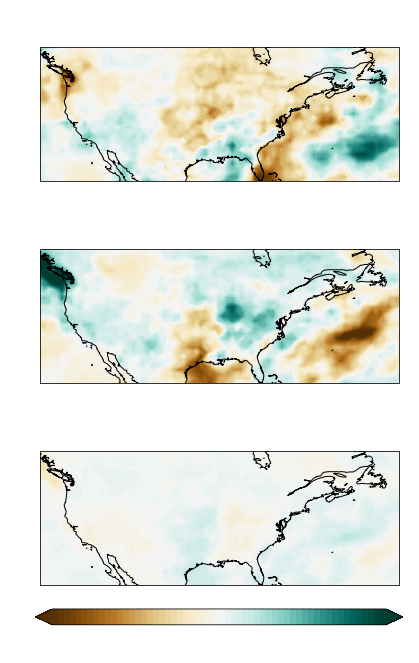

In [38]:
precip_bins = [posm,negm,neum];
lengths = [len(positive),len(negative),len(neutral)]
labels=['Positive','Negative', 'Neutral']
levels=np.linspace(-0.7,0.7,57)

fig, axs = plt.subplots(nrows=3,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8.5,11))

axs=axs.flatten()

n=0;
for enso in enumerate(precip_bins):
        data=precip_bins[n]['precip']
        cs=axs[n].contourf(precip_bins[n]['longitude'],precip_bins[n]['latitude'],data,levels=levels,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[n].set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[n].xaxis.set_major_formatter(lon_formatter)

        axs[n].set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[n].yaxis.set_major_formatter(lat_formatter)

        axs[n].set_title(labels[n]+' ('+str(lengths[n])+')')
        axs[n].coastlines()
        n+=1;

fig.subplots_adjust(bottom=0.25, top=0.93, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')
plt.suptitle('Composites: Precipitation Anomalies & MLSO index',weight='bold')
fig.savefig('mlso.compos.png')

### Calculating Differences

In [26]:
diffs = [posm-neum,negm-neum,posm-negm]

Text(0.5, 0.98, 'Differences in Composite Precipitation Anomalies for the MLSO index')

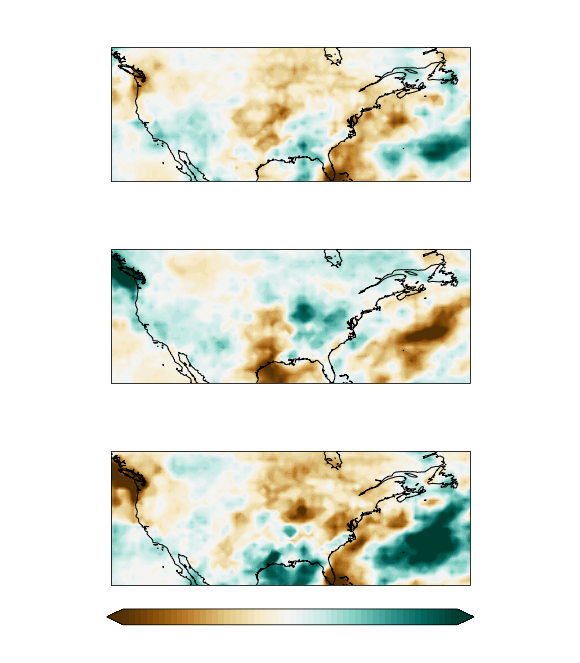

In [36]:
labels=['Positive - Neutral','Negative - Neutral', 'Positive - Negative']
levels=np.linspace(-0.7,0.7,57)

fig, axs = plt.subplots(nrows=3,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8.5,11))

axs=axs.flatten()

n=0;
for enso in enumerate(precip_bins):
        data=diffs[n]['precip']
        cs=axs[n].contourf(diffs[n]['longitude'],diffs[n]['latitude'],data,levels=levels,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[n].set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[n].xaxis.set_major_formatter(lon_formatter)

        axs[n].set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[n].yaxis.set_major_formatter(lat_formatter)

        axs[n].set_title(labels[n])
        axs[n].coastlines()
        n+=1;

fig.subplots_adjust(bottom=0.25, top=0.93, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')
plt.suptitle('Differences in Composite Precipitation Anomalies for the MLSO index',fontsize='x-large',weight='bold')

#### Determining Significance

In [28]:
from scipy.stats import ttest_ind

In [29]:
tstat1,pval1 = ttest_ind(pos['precip'], neu['precip'], 
                equal_var = False, nan_policy='omit')
tstat2,pval2 = ttest_ind(neg['precip'], neu['precip'], 
                equal_var = False, nan_policy='omit')
tstat3,pval3 = ttest_ind(pos['precip'], neg['precip'], 
                equal_var = False, nan_policy='omit')
#plt.contourf(pval3)
#plt.colorbar()

#### Creating Masks for hatching

In [30]:
p = 0.05;
mask1 = diffs[0]['precip'].where(pval1<p)
mask2 = diffs[1]['precip'].where(pval2<p)
mask3 = diffs[2]['precip'].where(pval3<p)
#plt.contourf(mask3)
#plt.colorbar()
masks = [mask1,mask2,mask3]

#### Plotting with Significance Hatching

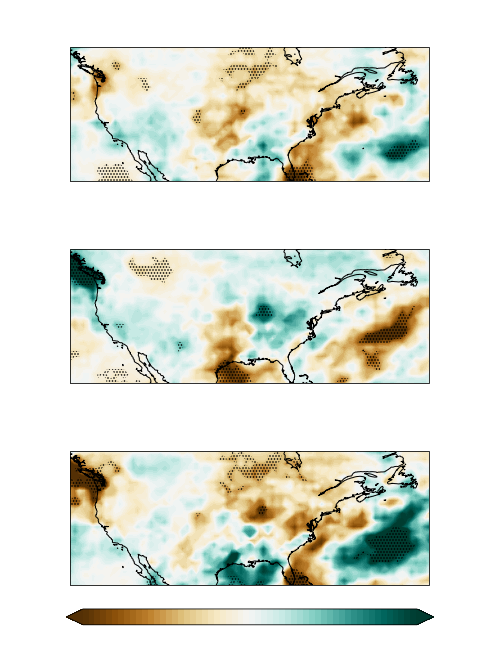

In [37]:
labels=['Positive - Neutral','Negative - Neutral', 'Positive - Negative']
levels=np.linspace(-0.7,0.7,57)
fig, axs = plt.subplots(nrows=3,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8.5,11))

axs=axs.flatten()

n=0;
for enso in enumerate(precip_bins):
        data=diffs[n]['precip']
        cs=axs[n].contourf(diffs[n]['longitude'],diffs[n]['latitude'],data,levels=levels,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[n].contourf(precip_bins[n]['longitude'],diffs[n]['latitude'],masks[n],[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['....'],extend='both',alpha=0) 
        
        
        axs[n].set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[n].xaxis.set_major_formatter(lon_formatter)

        axs[n].set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[n].yaxis.set_major_formatter(lat_formatter)

        axs[n].set_title(labels[n])
        axs[n].coastlines()
        n+=1;

fig.subplots_adjust(bottom=0.25, top=0.93, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')
plt.suptitle('Differences between Composite: Precipitation Anomalies & MLSO index',weight='bold')
fig.savefig('mlso.diffs.png')